# Olist Profit Optimization Plan

## 1. Problem statement (summarized)

>❓ How should Olist improve its profit ❓, given that it has 
> - some revenues per sellers per months
> - some revenues per orders
> - some reputation costs (estimated) per bad reviews
> - some operational costs of IT system that grows with number of orders, but not linearly (scale effects)


Our key findings so far :
- We have seen that `wait_time` was the most significant factor behind low review scores, but reading comments of the bad reviews also showed that some of them were linked to the seller or to the product itself.
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`. The latter being outside of Olist's direct control, improving it is not a quick-win recommendation we can make to Olist CEO without in-depth analysis of their operational practices.
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.

👉 The Seller analysis is started below, followed by investigation into other hypothesis

# Should we remove underperforming sellers from our marketplace ?** 🕵🏻

To analyse the impact of removing the worse sellers from Olist's marketplace, a what-if analysis is performed: What would have happened if Olist had never accepted these sellers in the first place? (granted, it's hard to know in advance who is a good seller, but this is a good starting point).

1️⃣ For each `seller_id`, the following aspects are computed and cumulated since the beginning:
- the `revenues` it brings
- the `costs` associated with all its bad reviews
- the resulting `profits` (revenues - costs)
- the number of `orders` (it will impact the overall IT costs)


2️⃣ Then:
- sellers are sorted by increasing profits for Olist
- for each number of sellers to remove, the financial impact it would have made if they had never been accepted on the platform is computed. 
- An optimal number of sellers to remove that maximizes Olist's profit margin is then calculated

👉 A detailed strategy (step by step) is written to create the DataFrame needed for the first step.

Starting from the current `seller().get_training_data()` DataFrame, is it possible to transform the data to compute:
- Olist's positive `revenue_per_seller`?
- Olist's `cost_of_bad_reviews`?

In [1]:
#Modules are imported
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Data is imported
from seller import Seller
from olist.product import Product

In [2]:
sellers = Seller().get_training_data()

sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70,341.870,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07,2290.307,2050.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00,15.800,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99,7.999,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99,16.799,-83.201


In [3]:
#Total profits brought in by sellers
sellers["profits"].sum()

1167608.4440000001

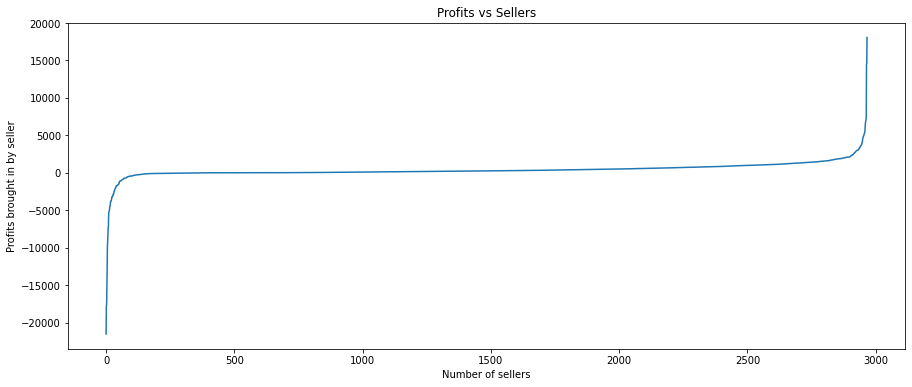

In [4]:
#Sorting sellers according to the profits they brought in
sellers_by_profits = sellers.sort_values(by = "profits")["profits"].reset_index()

#Visualizing the sellers according to the sorted profits; the sellers which brings in the least profits/most losses on the left,
#and sellers with the most profits on the right
plt.figure(figsize = (15, 6))
plt.plot(sellers_by_profits.index, sellers_by_profits["profits"])
plt.title("Profits vs Sellers")
plt.xlabel("Number of sellers")
plt.ylabel("Profits brought in by seller");

From the above graph, we know that there are a group of sellers which brought in losses to Olist. What is the impact to the company if we remove these sellers?

# Removing All Non-Profit Making Sellers

In [5]:
#Total number of orders brought in by sellers
sellers["n_orders"].sum()

99841

In [6]:
#As the total IT costs amount to 500000 BRL, we use it as a simple way to find the factor of IT costs for each seller
factor_per_seller = 500000 / (sellers["n_orders"]** 0.5).sum()

factor_per_seller

41.97705838297093

In [7]:
sellers_df = sellers.copy()

#Calculating IT costs for each seller
sellers_df["it_costs"] = sellers_df["n_orders"]** 0.5 * factor_per_seller

#Calculating net profits for each seller after deducting the IT cost
sellers_df["net_profits"] = sellers_df["profits"] - sellers_df["it_costs"]

sellers_df

#Calculating the total net profit from all sellers after deducting IT costs
sellers_df["net_profits"].sum()

667608.444

In [8]:
#Extracting the sellers that brings in losses after deducting all costs
sellers_df[sellers_df["net_profits"] < 0].head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits,it_costs,net_profits
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.0,1.0,5.0,0,1,1,1.0,158.00,15.800,15.800,41.977058,-26.177058
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.0,1.0,5.0,0,1,1,1.0,79.99,7.999,7.999,41.977058,-33.978058
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.0,0.0,1.0,100,1,1,1.0,167.99,16.799,-83.201,41.977058,-125.178058
5,c240c4061717ac1806ae6ee72be3533b,rio de janeiro,RJ,0.000000,6.056956,2018-05-08 17:55:23,2018-05-08 17:55:23,0.0,0.0,0.0,4.0,0,1,1,1.0,59.90,5.990,5.990,41.977058,-35.987058
13,05a48cc8859962767935ab9087417fbb,sao paulo,SP,0.000000,11.276516,2018-08-02 13:04:18,2018-08-02 13:04:18,0.0,0.0,1.0,5.0,0,1,1,1.0,42.90,4.290,4.290,41.977058,-37.687058


In [9]:
#Calculating the number of sellers that bring in losses after deducting all costs
sellers_df[sellers_df["net_profits"] < 0].count()["seller_id"]

1004

In [10]:
#Extracting sellers that brings in profits after deducting all costs
sellers_df[sellers_df["net_profits"] > 0].head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits,it_costs,net_profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.000000,140,3,3,1.000000,218.70,341.870,201.870,72.706398,129.163602
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.0,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.550000,240,40,41,1.025000,11703.07,2290.307,2050.307,265.486228,1784.820772
6,e49c26c3edfa46d227d5121a6b6e4d37,brejao,PE,0.0,11.653801,2017-02-04 19:31:42,2018-07-25 14:30:27,18.0,0.057143,0.742857,4.457143,330,35,36,1.028571,3654.25,1805.425,1475.425,248.339626,1227.085374
7,1b938a7ec6ac5061a66a3766e0e75f90,penapolis,SP,0.0,11.376438,2017-09-23 17:24:32,2018-08-18 19:09:29,11.0,0.100000,0.600000,4.300000,300,30,33,1.100000,3987.60,1278.760,978.760,229.917818,748.842182
8,768a86e36ad6aae3d03ee3c6433d61df,sao paulo,SP,0.0,5.081859,2018-06-19 12:18:24,2018-08-24 03:15:18,2.0,0.000000,0.705882,4.647059,40,17,17,1.000000,587.46,218.746,178.746,173.075846,5.670154


In [11]:
#Calculating the total net profits if all loss bearing sellers are removed
sellers_df[sellers_df["net_profits"] > 0]["net_profits"].sum()

1112157.658369466

In [12]:
#Adding function to label the bars in the bar charts
def valuelabel(profits):
    for i in range(len(profits)):
        plt.text(i,profits[i],profits[i], ha = 'center',
                 bbox = dict(facecolor = "white", alpha =0.8))

In [13]:
#Calculating profits before and after removal of loss making sellers
profit_before_removal = round(sellers_df["net_profits"].sum(), 2)
profit_after_removal = round(sellers_df[sellers_df["net_profits"] > 0]["net_profits"].sum(), 2)

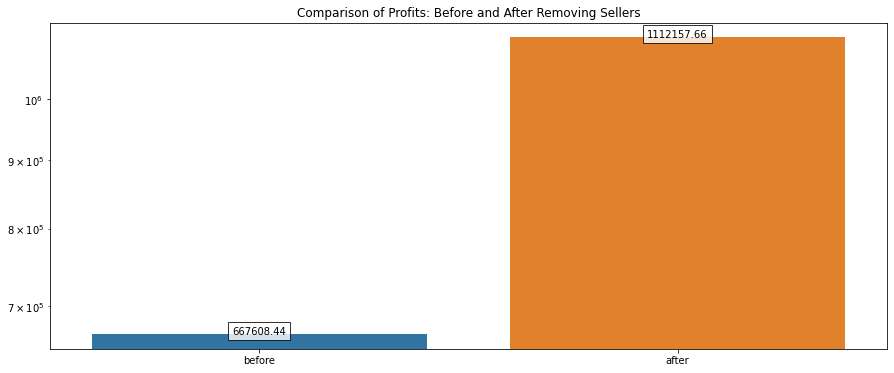

In [14]:
#Visualizing the profits before and after removal of loss making sellers in a bar chart
x = [1, 2]
profits = [profit_before_removal, profit_after_removal]

plt.figure(figsize = (15,6))
ax = sns.barplot(x = x, y = profits)
ax.set_yscale("log")
ax.set(title = "Comparison of Profits: Before and After Removing Sellers")
ax.set(xticklabels=["before", "after"])
valuelabel(profits)
plt.show();

In [15]:
print(f"PROFIT BEFORE REMOVAL: {profit_before_removal}")
print(f"PROFIT AFTER REMOVAL: {profit_after_removal}")
print(f"IMPROVEMENT: {((profit_after_removal - profit_before_removal)/profit_before_removal) * 100} %")

PROFIT BEFORE REMOVAL: 667608.44
PROFIT AFTER REMOVAL: 1112157.66
IMPROVEMENT: 66.58831634902639 %


# Optimizing based on number of sellers to remove

In [16]:
# As the total IT costs amount to 500000 BRL, we use it as a simple way to find the factor of IT costs for each order
factor_per_order = 500000/(sellers["n_orders"].sum()**0.5)
factor_per_order

1582.3973364219244

In [17]:
#Sorting sellers in the dataframe by the profits that they bring to the company
sorted_sellers = sellers.sort_values(by = "profits")

In [18]:
#Calculating the cumulated profits achieved after removing each seller (from the sellers with least profit/most losses, to the
#sellers with the most profits), and appending them to a list for visualisation purpose later
profit = []

for i in range(len(sorted_sellers)):
    
    tmp = sorted_sellers[i:]
    it_costs = (tmp["n_orders"].sum())**0.5 * factor_per_order
    total_profits = tmp["profits"].sum() - it_costs
    profit.append(total_profits)

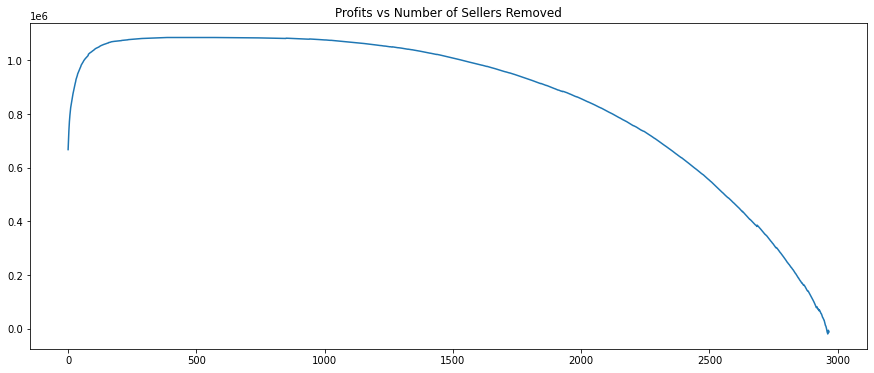

In [19]:
#Visualising the cumulative profits achieved after removing each seller, starting from the sellers with least profit/most losses,
#to the sellers with the most profits
x = [i for i in range(len(sorted_sellers))]
plt.figure(figsize = (15,6))
plt.plot(x, profit)
plt.title("Profits vs Number of Sellers Removed");

In [20]:
print(f"Number of sellers to remove: {profit.index(max(profit))}")

Number of sellers to remove: 486


In [21]:
#Calculating the number of sellers to remove to achieve max profit after taking into account the it costs scaling factor
profit.index(max(profit))

486

In [22]:
#Calculating the max profit after removing the 486 sellers with the lowest profit/max losses, and using it together with 
#the previous profit_before_removal (no removing of sellers) and profit_after_removal(removing all 1004 loss making sellers)
#to visualise the impact of removal of sellers towards the company profits
profit_max = round(sorted_sellers.iloc[487:]["profits"].sum(), 2)

x = [1, 2, 3]
y = [profit_before_removal, profit_after_removal, profit_max]

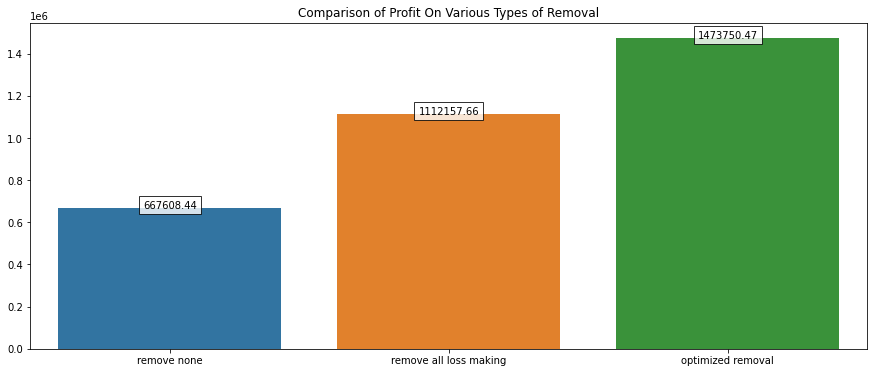

In [23]:
#Visualising the impact of removal of different numbers of sellers towards the company profits
plt.figure(figsize = (15,6))
bx = sns.barplot(x = x, y = y, order = [1, 2, 3])
bx.set(title = "Comparison of Profit On Various Types of Removal")
bx.set(xticklabels=["remove none", "remove all loss making", "optimized removal"])
valuelabel(y);

In [24]:
print(f"Profits after removing optimized number of sellers: {profit_max}")
print(f"IMPROVEMENT: {((profit_max - profit_before_removal)/profit_before_removal) * 100} %")

Profits after removing optimized number of sellers: 1473750.47
IMPROVEMENT: 120.75072478113069 %


# Optimizing Based on Months of Sellers

In [25]:
#Changing type of months_on_olist columns into integer for ease of manipulation
sellers_by_months = sellers.copy()
sellers_by_months["months_on_olist"] = sellers_by_months["months_on_olist"].astype("int64")

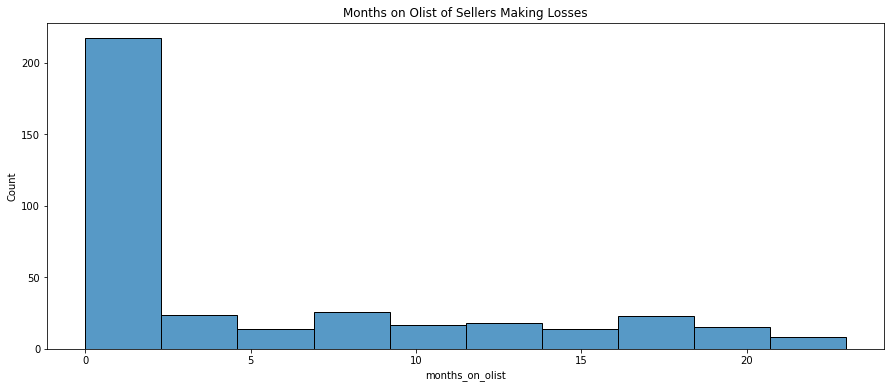

In [26]:
#Visualising the number of months of sellers in Olist platform that are making losses
plt.figure(figsize = (15,6))
ex = sns.histplot(sellers[sellers["profits"] < 0]["months_on_olist"])
ex.set(title = "Months on Olist of Sellers Making Losses");

Most of the sellers that are bringing losses on Olist have just been selling for one month in Olist. Are we going to remove these sellers altogether because they bring losses? If we remove them, have we considered the opportunity cost that this may bring (in terms of network effect and potential profit they may bring if they stay and improve their service)?

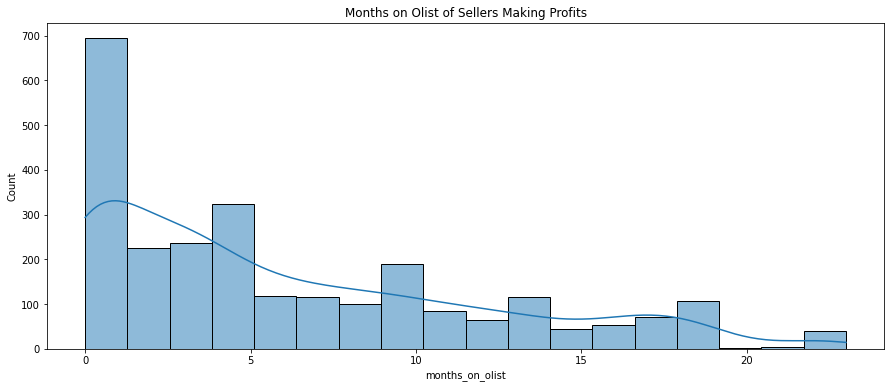

In [27]:
#Visualising the number of months of sellers that are making profits in Olist
plt.figure(figsize = (15,6))
fx = sns.histplot(sellers[sellers["profits"] > 0]["months_on_olist"], kde = True)
fx.set(title = "Months on Olist of Sellers Making Profits");

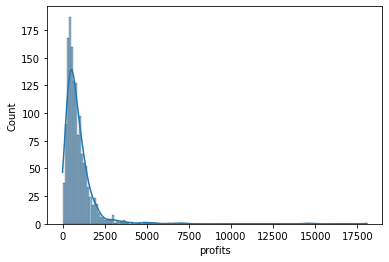

In [28]:
#Visualising the profit distribution of sellers if they break even after 4 months
sns.histplot(sellers.query("months_on_olist >= 4 and profits > 0")["profits"], kde = True);

In [29]:
#As this is a skewed data, we will be taking the median months of sellers making profit in Olist into consideration
#Calculating the average profits that a seller will bring if they make profit after four months. This is the opportunity cost 
#per seller
print(sellers[sellers["profits"] > 0]["months_on_olist"].median())
round(sellers.query("months_on_olist >= 4 and profits > 0")["profits"].median(), 2)

4.0


691.8

We can say that the median month on Olist for the seller that breaks even is 4 months. On average, the sellers that break even after four months will bring in BRL 691.80 of profits.

In [30]:
#Creating a dataframe based on the scenario that sellers are removed if they do not break even after four months
sellers_removed_by_months = sellers_by_months.query("(months_on_olist >= 4 and profits > 0) or (months_on_olist < 4)")

#Calculating the total it costs if we remove all orders based on the sellers that are removed by months
total_it_costs = (sellers_removed_by_months["n_orders"].sum())**0.5 * factor_per_order

#Calculating the net profit if we took into consideration the total_it_costs
profit_remove_by_months = round(sellers_removed_by_months["profits"].sum() - total_it_costs, 2)

In [31]:
#Calculating the number of sellers to remove if removal is based on 4 months
number_of_sellers_removed = sellers_by_months.query("(months_on_olist > 4 and profits < 0)").count()["seller_id"]
number_of_sellers_removed

135

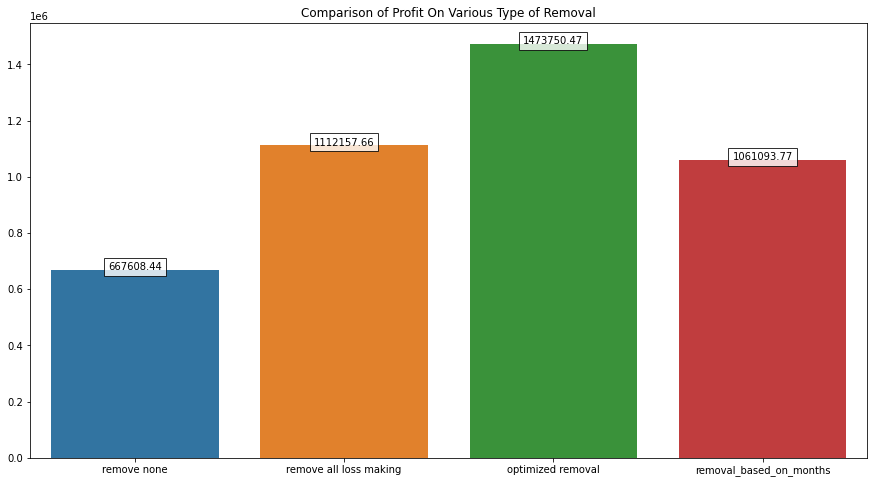

In [32]:
#Visualising the impact on the company profits based on removal of sellers by different methods
x = [1, 2, 3, 4]
y = [profit_before_removal, profit_after_removal, profit_max, profit_remove_by_months]

plt.figure(figsize = (15, 8))
cx = sns.barplot(x = x, y = y, order = [1, 2, 3, 4])
cx.set(title = "Comparison of Profit On Various Type of Removal")
cx.set(xticklabels=["remove none", "remove all loss making", "optimized removal", "removal_based_on_months"])
valuelabel(y);

In [33]:
print(f"Number of loss making sellers after 4 months: {number_of_sellers_removed}")
print(f"Profit after removing loss making sellers after 4 months: {profit_remove_by_months}")
print(f"IMPROVEMENT: {((profit_remove_by_months - profit_before_removal)/profit_before_removal) * 100} %")

Number of loss making sellers after 4 months: 135
Profit after removing loss making sellers after 4 months: 1061093.77
IMPROVEMENT: 58.93953797228808 %
